<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP6/Pr%C3%A1ctica_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 6:  Convolución

##Presentado por: Ronny Guevara

## Objetivo General
Filtrar una imagen utilizando técnicas de convolución  
## Objetivos Específicos
*   Contruir filtros pasa bajos, pasa altos, pasa banda, detectores de borde y direccionales utilizando convolución
*   Generación de kernels apropiados
*   Visualización de resultados en una interfaz amigable con el usuario

## Descripción del práctico:
Las actividades propuestas son:

*   Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
*   Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
*   Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4


In [1]:
#Librerías a utilizar
import cv2
from PIL import Image, ImageFilter
import tempfile
import imageio as io
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time
from google.colab import files
import math

In [2]:
#Función que permite leer una imagen sin limitación de UNIT8
def get_image(dir):
  image = io.imread(dir)
  image = image.astype(np.int)
  return image

#Función que permite plotear la imagen
def plot2_image(image,Imagen, cmap=None):
  plt.figure(figsize=(100,100)) 
  plt.figure()
  plt.title(Imagen)
  plt.imshow(image,cmap=cmap)
  plt.grid(False)
  plt.show()

#Copia de la imagen Original
def image_copy(image):
  work_image=np.copy(image)
  return work_image 

#Información de la imagen
def image_info(image):
  print('This image is', image.dtype)
  print('with dimensions', image.shape)

#Normalización de las imágenes
def image_norm(image):
  norm=image.astype(np.float64)/255
  return norm

#Conversión RGB2YIQ
def image_RGB2YIQ(image):
  matrixYIQ=np.array([[0.299,0.587,0.144],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
  YIQ=np.dot(image,matrixYIQ)
  y = YIQ[:,:,0]
  i = YIQ[:,:,1]
  q = YIQ[:,:,2]
  y = np.clip(y, 0 ,1)
  q = np.clip(q,-0.5957 , 0.5957 )
  i = np.clip(i, -0.5226 , 0.5226) 
  return y, i, q

#Construcción de la imagen a partir de las componentes YIQ
def yiq_to_image(y,i,q):
  Shape = y.shape
  im_out = np.zeros((Shape[0], Shape[1], 3))
  im_out[:,:,0] = y
  im_out[:,:,1] = i
  im_out[:,:,2] = q
  return im_out.astype(np.float64)
  
#Conversión YIQ2RGB
def image_YIQ2RGB(image):
  matrixRGB=np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
  RGB=np.dot(image,matrixRGB)
  RGB=RGB.clip(0,1)*255
  RGB=RGB.astype(np.uint8)
  return RGB

In [24]:
#Función que permite obtener la transformada de Fourier
def fft_imagen(y):
  fc = np.fft.fftshift(np.fft.fft2(y)) #numpy
  mag = np.abs(fc)
  mag = np.log(mag + 1)
  phase = np.angle(fc) 
  return mag, phase

#Función que permite obtener la transformada inversa de Fourier
def ifft_imagen(mag, phase):
  image_final=(np.power(np.e, mag) - 1) * (np.cos(phase) + np.sin(phase) * 1j)
  image_final=np.abs(fftpack.ifft2(fftpack.ifftshift(image_final)))
  image_final=np.clip(image_final,0 ,255)
  return image_final

#Función padding
def padding (image1, dato):
  f1, c1, _ = image1.shape
  dato = dato - 1
  dato2 = (dato * 2/3)
  dato3 = math.trunc(dato2)
  fmax = f1 + dato
  cmax = c1 + dato
  im1_new = np.zeros ((fmax, cmax,3), dtype='float')
  for i in range(f1):
    for j in range(c1): 
      im1_new[i+dato3,j+dato3,:] = image1[i,j,:]
  return im1_new, fmax, cmax, dato3, f1, c1

#Función de convolución
def low_pass_filter(y, kernel):
  im = y.copy() / y.max()
  im_h = im.shape[0] 
  im_w = im.shape[1]
  k_h = kernel.shape[0]
  k_w = kernel.shape[1]
  pdh_h = (k_h - 1) // 2
  pdh_w = (k_w - 1) // 2
  out = np.zeros(im.shape) 
  for row in range(im_h):
    for col in range(im_w):
      range_w = range((col - pdh_w), (col + pdh_w + 1))
      range_h = range((row - pdh_h), (row + pdh_h + 1))
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)
      sub_im = im[np.ix_(idx_h,idx_w)]
      out[row,col] = np.multiply(sub_im,kernel).sum()
  return out

Incluido el drive en el trabajo se procede a leer las imagenes, permitiendo al usuario seleccionar la imagen que desee.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<Figure size 7200x7200 with 0 Axes>

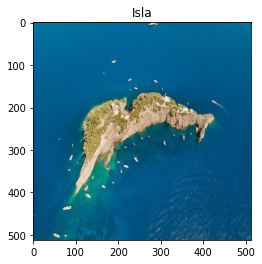

In [5]:
#@title Selecciona la imagen { run: "auto" }
Loro='/content/drive/MyDrive/Colab Notebooks/loro.jpg'
Ciudad='/content/drive/MyDrive/Colab Notebooks/Ciudad.jpg'
SistemaSolar='/content/drive/MyDrive/Colab Notebooks/SisSolar.jpg'
Coliseo='/content/drive/MyDrive/Colab Notebooks/Coliseo.jpg'
Isla='/content/drive/MyDrive/Colab Notebooks/Isla.jpg'
Selva='/content/drive/MyDrive/Colab Notebooks/Selva.jpg'
Imagen = 'Isla' #@param ["Loro", "Ciudad", "SistemaSolar", "Coliseo", "Isla", "Selva"]

if Imagen == 'Loro':
  image = get_image(Loro)
  plot2_image(image, 'Loro')
elif Imagen == 'Ciudad':
  image = get_image(Ciudad)
  plot2_image(image, 'Ciudad')
elif Imagen == 'SistemaSolar':
  image = get_image(SistemaSolar)
  plot2_image(image, 'SistemaSolar')
elif Imagen == 'Isla':
  image = get_image(Isla)
  plot2_image(image, 'Isla')
elif Imagen == 'Selva':
  image = get_image(Selva)
  plot2_image(image, 'Selva')
elif Imagen == 'Coliseo':
  image = get_image(Coliseo)
  plot2_image(image, 'Coliseo')

In [6]:
#Proceso de copia de la imagen y visualización de información
work_image=image_copy(image)
image_info(work_image)

This image is int64
with dimensions (512, 512, 3)


<Figure size 7200x7200 with 0 Axes>

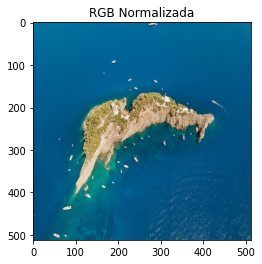

In [7]:
#Normalización de la imagen y conversión del espacio RGB a YIQ
work_image=image_norm(work_image)
plot2_image(work_image,'RGB Normalizada',cmap=None)

<Figure size 7200x7200 with 0 Axes>

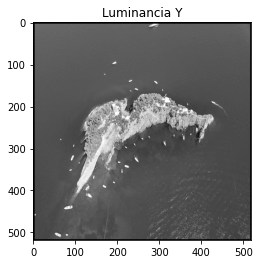

In [8]:
ima, fmax, cmax, dato, f1, c1 = padding (work_image, 7)
y, i, q = image_RGB2YIQ(ima)
plot2_image(y,'Luminancia Y',cmap='gray')

#### Visualización individual de los filtros
#### Filtros de convolución
Convolución es el tratamiento de una matriz por otra que se llama “kernel”. El filtro matriz de convolución usa una primera matriz que es la imagen que será tratada. La imagen es una colección bidimensional de píxeles en coordenada rectágular. El kernel usado depende del efecto deseado.

In [9]:
#Kernels para FILTRO PASA BAJOS LLANO
kernel3=np.array([[1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]])
kernel5=np.array([[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04]])
kernel7=np.array([[0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816],[0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816]])

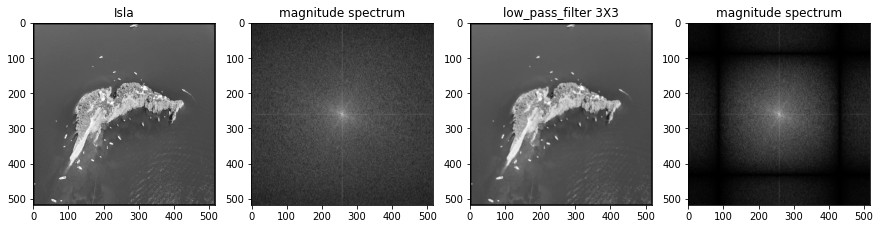

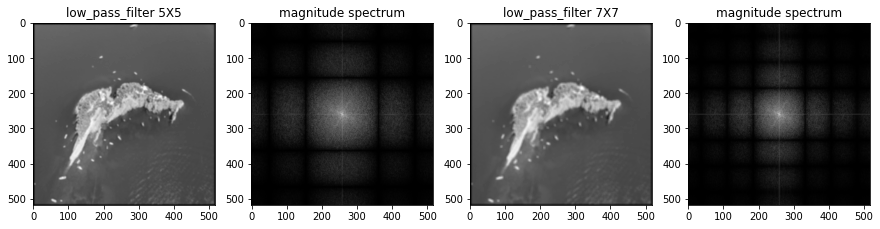

In [10]:
#FILTRO PASA BAJOS LLANO
mag, phase = fft_imagen (y)
new_imagen1=low_pass_filter(y,kernel3)
new_imagen2=low_pass_filter(y,kernel5)
new_imagen3=low_pass_filter(y,kernel7)
mag1, phase1 = fft_imagen (new_imagen1)
mag2, phase2 = fft_imagen (new_imagen2)
mag3, phase3 = fft_imagen (new_imagen3)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagen1, 'gray')
axes[2].set_title('low_pass_filter 3X3')
axes[3].imshow(mag1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_imagen2,'gray')
axes[0].set_title('low_pass_filter 5X5')
axes[1].imshow(mag2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagen3,'gray')
axes[2].set_title('low_pass_filter 7X7')
axes[3].imshow(mag3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()


In [11]:
#Kernels para FILTRO PASA BAJO BARTLETT
kernel3b=np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
kernel5b=np.array([[1/81, 2/81, 3/81, 2/81, 1/81],[2/81, 4/81, 6/81, 4/81, 2/81], [3/81, 6/81, 9/81, 6/81, 3/81],[2/81, 4/81, 6/81, 4/81, 2/81], [1/81, 2/81, 3/81, 2/81, 1/81] ])
kernel7b=np.array([[1/256, 2/256, 3/256, 4/256, 3/256, 2/256, 1/256], [2/256, 4/256, 6/256, 8/256, 6/256, 4/256, 2/256], [3/256, 6/256, 9/256, 12/256, 9/256, 6/256, 3/256], [4/256, 8/256, 12/256, 16/256, 12/256, 8/256, 4/256], [3/256, 6/256, 9/256, 12/256, 9/256, 6/256, 3/256], [2/256, 4/256, 6/256, 8/256, 6/256, 4/256, 2/256], [1/256, 2/256, 3/256, 4/256, 3/256, 2/256, 1/256]])

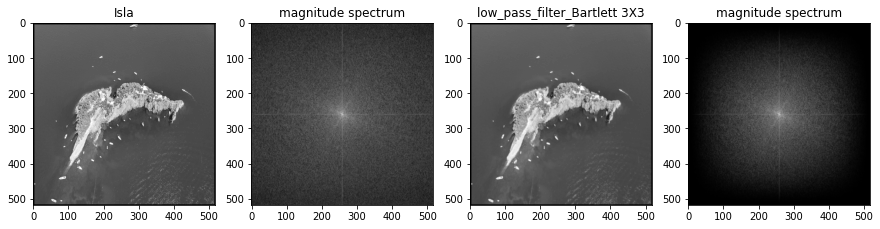

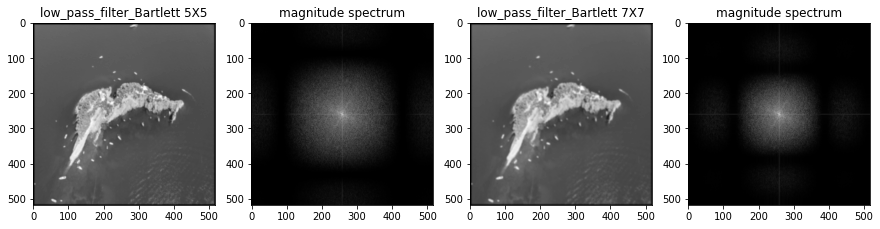

In [12]:
#FILTRO PASA BAJO BARTLETT
mag, phase = fft_imagen (y)
new_imagenb1=low_pass_filter(y,kernel3b)
new_imagenb2=low_pass_filter(y,kernel5b)
new_imagenb3=low_pass_filter(y,kernel7b)
magb1, phaseb1 = fft_imagen (new_imagenb1)
magb2, phaseb2 = fft_imagen (new_imagenb2)
magb3, phaseb3 = fft_imagen (new_imagenb3)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagenb1, 'gray')
axes[2].set_title('low_pass_filter_Bartlett 3X3')
axes[3].imshow(magb1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_imagenb2,'gray')
axes[0].set_title('low_pass_filter_Bartlett 5X5')
axes[1].imshow(magb2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagenb3,'gray')
axes[2].set_title('low_pass_filter_Bartlett 7X7')
axes[3].imshow(magb3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

In [13]:
#Kernels para FILTRO PASA BAJO GAUSSIANO
kernel3g=np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
kernel5g=np.array([[1/256, 4/256, 6/256, 4/256, 1/256],[4/256, 16/256, 24/256, 16/256, 4/256], [6/256, 24/256, 36/256, 24/256, 6/256], [4/256, 16/256, 24/256, 16/256, 4/256],[1/256, 4/256, 6/256, 4/256, 1/256]])
kernel7g=np.array([[1/3880, 6/3880, 15/3880, 20/3880, 15/3880, 6/3880, 1/3880],[6/3880, 36/3880, 90/3880, 120/3880, 90/3880, 36/3880, 16/3880], [15/3880, 90/3880, 225/3880, 300/3880, 225/3880, 90/3880, 15/3880],
                   [20/3880, 120/3880, 300/3880, 400/3880, 300/3880, 120/3880, 20/3880], [15/3880, 90/3880, 225/3880, 300/3880, 225/3880, 90/3880, 15/3880], [6/3880, 36/3880, 90/3880, 120/3880, 90/3880, 36/3880, 6/3880], [1/3880, 6/3880, 15/3880, 20/3880, 15/3880, 6/3880, 1/3880]])

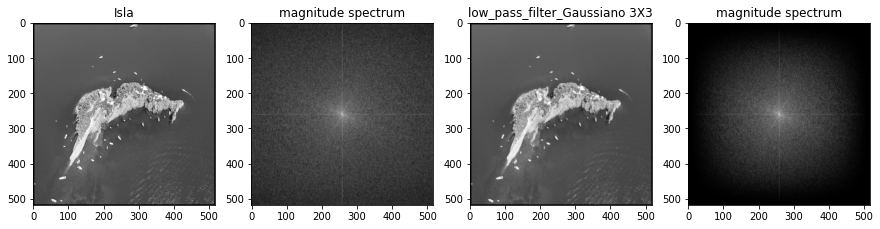

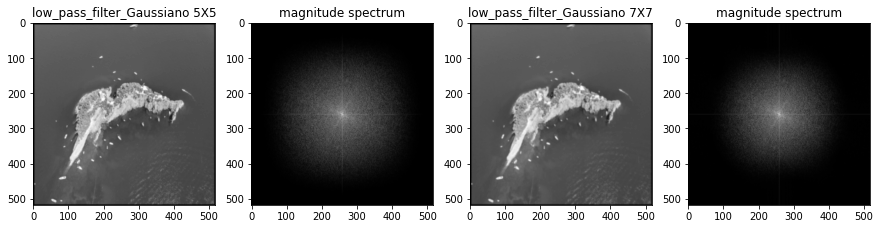

In [14]:
#FILTRO PASA BAJO GAUSSIANO
mag, phase = fft_imagen (y)
new_imageng1=low_pass_filter(y,kernel3g)
new_imageng2=low_pass_filter(y,kernel5g)
new_imageng3=low_pass_filter(y,kernel7g)
magg1, phaseb1 = fft_imagen (new_imageng1)
magg2, phaseb2 = fft_imagen (new_imageng2)
magg3, phaseb3 = fft_imagen (new_imageng3)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imageng1, 'gray')
axes[2].set_title('low_pass_filter_Gaussiano 3X3')
axes[3].imshow(magg1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_imageng2,'gray')
axes[0].set_title('low_pass_filter_Gaussiano 5X5')
axes[1].imshow(magg2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imageng3,'gray')
axes[2].set_title('low_pass_filter_Gaussiano 7X7')
axes[3].imshow(magg3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

In [15]:
#Kernels para FILTRO DETECTOR DE BORDES LAPLACIANO
kernelv4=np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])
kernelv8=np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])

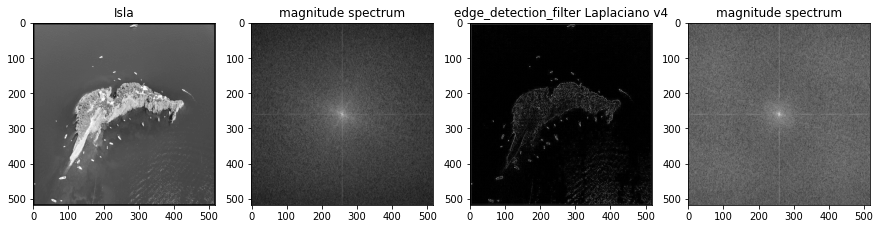

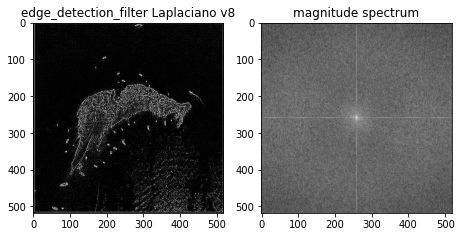

In [16]:
#FILTRO DETECTOR DE BORDES LAPLACIANO
mag, phase = fft_imagen (y)
new_imagelv4=low_pass_filter(y,kernelv4)
new_imagelv4=np.clip(new_imagelv4,0,1)
new_imagelv8=low_pass_filter(y,kernelv8)
new_imagelv8=np.clip(new_imagelv8,0,1)
magl1, phasel1 = fft_imagen (new_imagelv4)
magl2, phasel2 = fft_imagen (new_imagelv8)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagelv4, 'gray')
axes[2].set_title('edge_detection_filter Laplaciano v4')
axes[3].imshow(magl1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7.5,7.5)
axes[0].imshow(new_imagelv8,'gray')
axes[0].set_title('edge_detection_filter Laplaciano v8')
axes[1].imshow(magl2, 'gray')
axes[1].set_title('magnitude spectrum')
plt.show()

In [17]:
#Kernels para FILTROS DIRECCIONALES
kernels1=np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])#Este
kernels2=np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])#Norte
kernels3=np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])#Oeste
kernels4=np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])#Sur

kernels5=np.array([[0, 1, 2],[-1, 0, 1],[-2, -1, 0]])#NE
kernels6=np.array([[2, 1, 0],[1, 0, -1],[0, -1, -2]])#SE
kernels7=np.array([[0, -1, -2],[1, 0, -1],[2, 1, 0]])#NO
kernels8=np.array([[-2, -1, 0],[-1, 0, 1],[0, 1, 2]])#SO

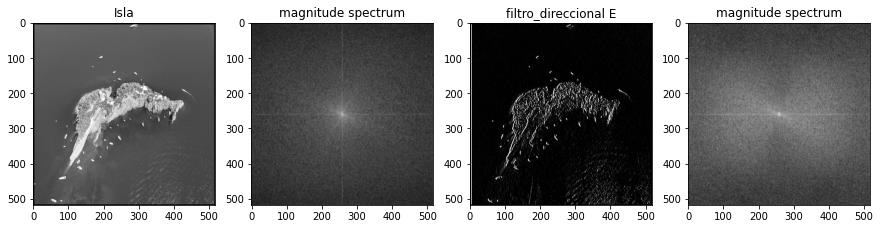

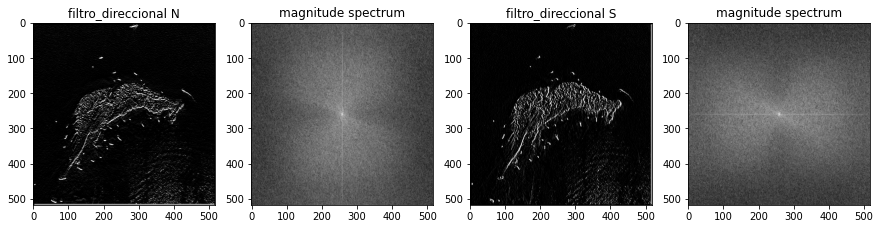

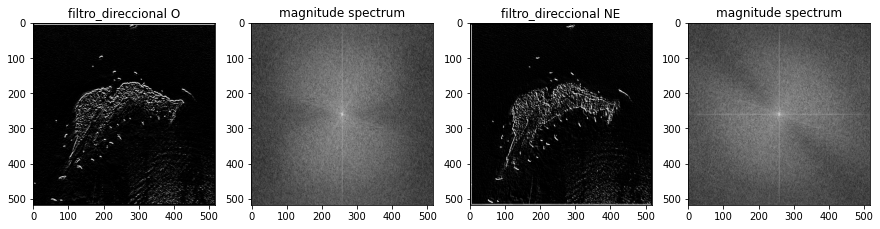

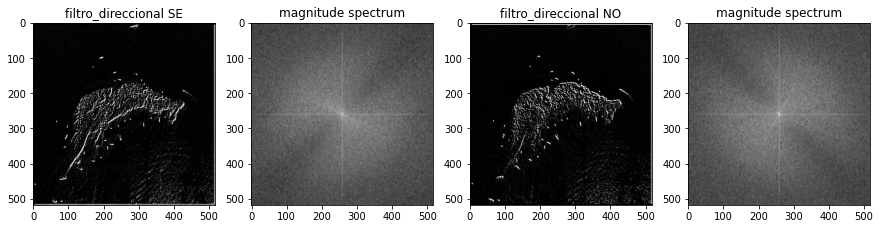

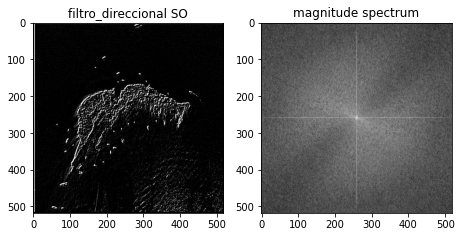

In [18]:
#FILTROS DIRECCIONALES
mag, phase = fft_imagen (y)
new_images1=low_pass_filter(y,kernels1)
new_images1=np.clip(new_images1,0,1)
new_images2=low_pass_filter(y,kernels2)
new_images2=np.clip(new_images2,0,1)
new_images3=low_pass_filter(y,kernels3)
new_images3=np.clip(new_images3,0,1)
new_images4=low_pass_filter(y,kernels4)
new_images4=np.clip(new_images4,0,1)

new_images5=low_pass_filter(y,kernels5)
new_images5=np.clip(new_images5,0,1)
new_images6=low_pass_filter(y,kernels6)
new_images6=np.clip(new_images6,0,1)
new_images7=low_pass_filter(y,kernels7)
new_images7=np.clip(new_images7,0,1)
new_images8=low_pass_filter(y,kernels8)
new_images8=np.clip(new_images8,0,1)

mags1, phases1 = fft_imagen (new_images1)
mags2, phases2 = fft_imagen (new_images2)
mags3, phases3 = fft_imagen (new_images3)
mags4, phases4 = fft_imagen (new_images4)

mags5, phases5 = fft_imagen (new_images5)
mags6, phases6 = fft_imagen (new_images6)
mags7, phases7 = fft_imagen (new_images7)
mags8, phases8 = fft_imagen (new_images8)

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images1, 'gray')
axes[2].set_title('filtro_direccional E')
axes[3].imshow(mags1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_images2,'gray')
axes[0].set_title('filtro_direccional N')
axes[1].imshow(mags2, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images3,'gray')
axes[2].set_title('filtro_direccional S')
axes[3].imshow(mags3, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_images4,'gray')
axes[0].set_title('filtro_direccional O')
axes[1].imshow(mags4, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images5,'gray')
axes[2].set_title('filtro_direccional NE')
axes[3].imshow(mags5, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(new_images6,'gray')
axes[0].set_title('filtro_direccional SE')
axes[1].imshow(mags6, 'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_images7,'gray')
axes[2].set_title('filtro_direccional NO')
axes[3].imshow(mags7, 'gray')
axes[3].set_title('magnitude spectrum')
plt.show()

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7.5,7.5)
axes[0].imshow(new_images8,'gray')
axes[0].set_title('filtro_direccional SO')
axes[1].imshow(mags8, 'gray')
axes[1].set_title('magnitude spectrum')
plt.show()

In [19]:
#Kernels para FILTRO PASA BANDA
kernelpb=np.array([[-1, -4, -6, -4, -1],[-4, 0, 8, 0, -4],[-6, 8, 28, 8, -6],[-4, 0, 8, 0, -4], [-1, -4, -6, -4, -1]])


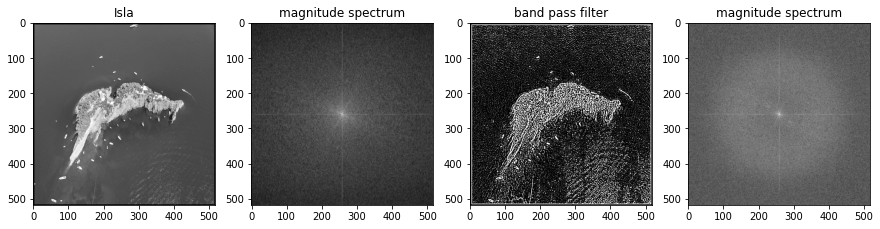

In [20]:
#FILTRO PASA BANDA
mag, phase = fft_imagen (y)
new_imagepb=low_pass_filter(y,kernelpb)
new_imagepb=np.clip(new_imagepb,0,1)

magpb, phasepb = fft_imagen (new_imagepb)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagepb, 'gray')
axes[2].set_title('band pass filter')
axes[3].imshow(magpb,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()


In [21]:
#Kernels para FILTRO PASA ALTOS
kernelpa1=np.array([[1, -4, 6,-4,1],[-4, 16, -24, 16, -4],[6, -24, 36, -24, 6],[-4, 16, -24, 16, -4], [1, -4, 6,-4,1]])
kernelpa2=np.array([[1, 4, -10, 4, 1],[4, 16, -40, 16, 4],[-10, -40, 100, -40, -10],[4, 16, -40, 16, 4], [1, 4, -10, 4, 1]])

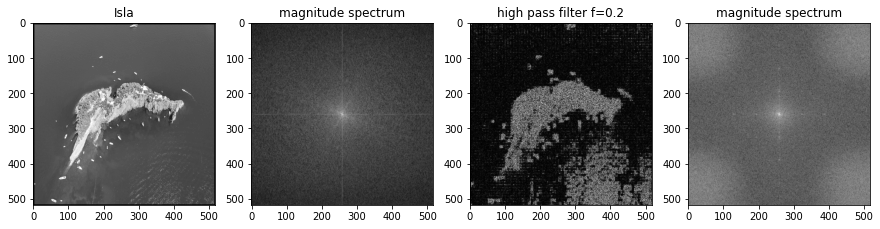

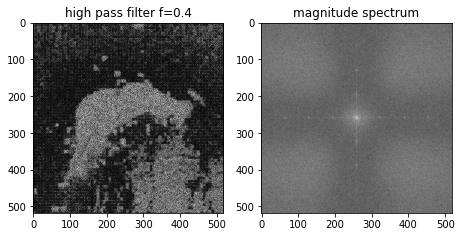

In [22]:
#FILTRO PASA ALTOS
mag, phase = fft_imagen (y)
new_imagepa1=low_pass_filter(y,kernelpa1)
new_imagepa1=np.clip(new_imagepa1,0,1)
new_imagepa2=low_pass_filter(y,kernelpa2)
new_imagepa2=np.clip(new_imagepa2,0,1)
magpa1, phasepa1 = fft_imagen (new_imagepa1)
magpa2, phasepa2 = fft_imagen (new_imagepa2)
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(mag,'gray')
axes[1].set_title('magnitude spectrum')
axes[2].imshow(new_imagepa1, 'gray')
axes[2].set_title('high pass filter f=0.2')
axes[3].imshow(magpa1,'gray')
axes[3].set_title('magnitude spectrum')
plt.show()
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7.5,7.5)
axes[0].imshow(new_imagepa2, 'gray')
axes[0].set_title('high pass filter f=0.4')
axes[1].imshow(magpa2,'gray')
axes[1].set_title('magnitude spectrum')
plt.show()


###Resultados

Desarrollo del aplicativo que permite, levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución:

*   Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
*   Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
*   Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4

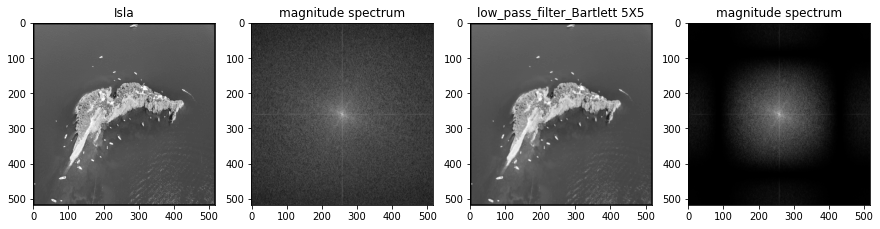

In [23]:
#@title Resultados { run: "auto" }
Filter = 'pass_bass_Bartlett' #@param ["pass_bass", "pass_bass_Bartlett" ,"pass_high","band_pass_filter", "directional_filter", "edge_detector_filter"]
Type = '5X5' #@param ["3X3", "5X5","7X7"] {allow-input: true}

if Filter == 'pass_bass' and Type=='3X3':
  kernel3g=np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
  new_imagen1=low_pass_filter(y,kernel3)
  mag1, phase1 = fft_imagen (new_imagen1)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagen1, 'gray')
  axes[2].set_title('low_pass_filter 3X3')
  axes[3].imshow(mag1,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'pass_bass' and Type=='5X5':
  kernel5=np.array([[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04],[0.04, 0.04, 0.04, 0.04, 0.04]])  
  new_imagen2=low_pass_filter(y,kernel5)
  mag2, phase2 = fft_imagen (new_imagen2)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagen2, 'gray')
  axes[2].set_title('low_pass_filter 5X5')
  axes[3].imshow(mag2,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'pass_bass' and Type=='7X7':
  kernel7=np.array([[0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816],[0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816], [0.02040816 , 0.02040816 , 0.02040816 , 0.02040816 , 0.02040816, 0.02040816, 0.02040816]])  
  new_imagen3=low_pass_filter(y,kernel7)
  mag3, phase3 = fft_imagen (new_imagen3)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagen3, 'gray')
  axes[2].set_title('low_pass_filter 7X7')
  axes[3].imshow(mag3,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'pass_bass_Bartlett' and Type=='3X3':
  kernel3b=np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]])
  mag, phase = fft_imagen (y)
  new_imagenb1=low_pass_filter(y,kernel3b)
  magb1, phaseb1 = fft_imagen (new_imagenb1)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagenb1, 'gray')
  axes[2].set_title('low_pass_filter_Bartlett 3X3')
  axes[3].imshow(magb1,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'pass_bass_Bartlett' and Type=='5X5':
  kernel5b=np.array([[1/81, 2/81, 3/81, 2/81, 1/81],[2/81, 4/81, 6/81, 4/81, 2/81], [3/81, 6/81, 9/81, 6/81, 3/81],[2/81, 4/81, 6/81, 4/81, 2/81], [1/81, 2/81, 3/81, 2/81, 1/81] ])
  mag, phase = fft_imagen (y)
  new_imagenb2=low_pass_filter(y,kernel5b)
  magb2, phaseb2 = fft_imagen (new_imagenb2)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagenb1, 'gray')
  axes[2].set_title('low_pass_filter_Bartlett 5X5')
  axes[3].imshow(magb2,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show() 
elif Filter == 'pass_bass_Bartlett' and Type=='7X7':
  kernel7b=np.array([[1/256, 2/256, 3/256, 4/256, 3/256, 2/256, 1/256], [2/256, 4/256, 6/256, 8/256, 6/256, 4/256, 2/256], [3/256, 6/256, 9/256, 12/256, 9/256, 6/256, 3/256], [4/256, 8/256, 12/256, 16/256, 12/256, 8/256, 4/256], [3/256, 6/256, 9/256, 12/256, 9/256, 6/256, 3/256], [2/256, 4/256, 6/256, 8/256, 6/256, 4/256, 2/256], [1/256, 2/256, 3/256, 4/256, 3/256, 2/256, 1/256]])
  mag, phase = fft_imagen (y)
  new_imagenb3=low_pass_filter(y,kernel7b)
  magb3, phaseb3 = fft_imagen (new_imagenb3)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagenb3, 'gray')
  axes[2].set_title('low_pass_filter_Bartlett 7X7')
  axes[3].imshow(magb3,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show() 
elif Filter == 'pass_high':
  kernelpa1=np.array([[1, -4, 6,-4,1],[-4, 16, -24, 16, -4],[6, -24, 36, -24, 6],[-4, 16, -24, 16, -4], [1, -4, 6,-4,1]])
  kernelpa2=np.array([[1, 4, -10, 4, 1],[4, 16, -40, 16, 4],[-10, -40, 100, -40, -10],[4, 16, -40, 16, 4], [1, 4, -10, 4, 1]])
  mag, phase = fft_imagen (y)
  new_imagepa1=low_pass_filter(y,kernelpa1)
  new_imagepa1=np.clip(new_imagepa1,0,1)
  new_imagepa2=low_pass_filter(y,kernelpa2)
  new_imagepa2=np.clip(new_imagepa2,0,1)
  magpa1, phasepa1 = fft_imagen (new_imagepa1)
  magpa2, phasepa2 = fft_imagen (new_imagepa2)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagepa1, 'gray')
  axes[2].set_title('high pass filter f=0.2')
  axes[3].imshow(magpa1,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(7.5,7.5)
  axes[0].imshow(new_imagepa2, 'gray')
  axes[0].set_title('high pass filter f=0.4')
  axes[1].imshow(magpa2,'gray')
  axes[1].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'band_pass_filter':
  kernelpb=np.array([[-1, -4, -6, -4, -1],[-4, 0, 8, 0, -4],[-6, 8, 28, 8, -6],[-4, 0, 8, 0, -4], [-1, -4, -6, -4, -1]])
  mag, phase = fft_imagen (y)
  new_imagepb=low_pass_filter(y,kernelpb)
  new_imagepb=np.clip(new_imagepb,0,1)

  magpb, phasepb = fft_imagen (new_imagepb)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagepb, 'gray')
  axes[2].set_title('band pass filter')
  axes[3].imshow(magpb,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'directional_filter':
  kernels1=np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])#Este
  kernels2=np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])#Norte
  kernels3=np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])#Oeste
  kernels4=np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])#Sur

  kernels5=np.array([[0, 1, 2],[-1, 0, 1],[-2, -1, 0]])#NE
  kernels6=np.array([[2, 1, 0],[1, 0, -1],[0, -1, -2]])#SE
  kernels7=np.array([[0, -1, -2],[1, 0, -1],[2, 1, 0]])#NO
  kernels8=np.array([[-2, -1, 0],[-1, 0, 1],[0, 1, 2]])#SO
  mag, phase = fft_imagen (y)
  new_images1=low_pass_filter(y,kernels1)
  new_images1=np.clip(new_images1,0,1)
  new_images2=low_pass_filter(y,kernels2)
  new_images2=np.clip(new_images2,0,1)
  new_images3=low_pass_filter(y,kernels3)
  new_images3=np.clip(new_images3,0,1)
  new_images4=low_pass_filter(y,kernels4)
  new_images4=np.clip(new_images4,0,1)

  new_images5=low_pass_filter(y,kernels5)
  new_images5=np.clip(new_images5,0,1)
  new_images6=low_pass_filter(y,kernels6)
  new_images6=np.clip(new_images6,0,1)
  new_images7=low_pass_filter(y,kernels7)
  new_images7=np.clip(new_images7,0,1)
  new_images8=low_pass_filter(y,kernels8)
  new_images8=np.clip(new_images8,0,1)

  mags1, phases1 = fft_imagen (new_images1)
  mags2, phases2 = fft_imagen (new_images2)
  mags3, phases3 = fft_imagen (new_images3)
  mags4, phases4 = fft_imagen (new_images4)

  mags5, phases5 = fft_imagen (new_images5)
  mags6, phases6 = fft_imagen (new_images6)
  mags7, phases7 = fft_imagen (new_images7)
  mags8, phases8 = fft_imagen (new_images8)

  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_images1, 'gray')
  axes[2].set_title('filtro_direccional E')
  axes[3].imshow(mags1,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()

  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(new_images2,'gray')
  axes[0].set_title('filtro_direccional N')
  axes[1].imshow(mags2, 'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_images3,'gray')
  axes[2].set_title('filtro_direccional S')
  axes[3].imshow(mags3, 'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()

  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(new_images4,'gray')
  axes[0].set_title('filtro_direccional O')
  axes[1].imshow(mags4, 'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_images5,'gray')
  axes[2].set_title('filtro_direccional NE')
  axes[3].imshow(mags5, 'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()

  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(new_images6,'gray')
  axes[0].set_title('filtro_direccional SE')
  axes[1].imshow(mags6, 'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_images7,'gray')
  axes[2].set_title('filtro_direccional NO')
  axes[3].imshow(mags7, 'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()

  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(7.5,7.5)
  axes[0].imshow(new_images8,'gray')
  axes[0].set_title('filtro_direccional SO')
  axes[1].imshow(mags8, 'gray')
  axes[1].set_title('magnitude spectrum')
  plt.show()
elif Filter == 'edge_detector_filter':
  kernelv4=np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])
  kernelv8=np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
  mag, phase = fft_imagen (y)
  new_imagelv4=low_pass_filter(y,kernelv4)
  new_imagelv4=np.clip(new_imagelv4,0,1)
  new_imagelv8=low_pass_filter(y,kernelv8)
  new_imagelv8=np.clip(new_imagelv8,0,1)
  magl1, phasel1 = fft_imagen (new_imagelv4)
  magl2, phasel2 = fft_imagen (new_imagelv8)
  fig, axes = plt.subplots(1, 4)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(mag,'gray')
  axes[1].set_title('magnitude spectrum')
  axes[2].imshow(new_imagelv4, 'gray')
  axes[2].set_title('edge_detection_filter Laplaciano v4')
  axes[3].imshow(magl1,'gray')
  axes[3].set_title('magnitude spectrum')
  plt.show()
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(7.5,7.5)
  axes[0].imshow(new_imagelv8,'gray')
  axes[0].set_title('edge_detection_filter Laplaciano v8')
  axes[1].imshow(magl2, 'gray')
  axes[1].set_title('magnitude spectrum')
  plt.show()

#### Análisis de los resultados:



*   Se crea una función que permite realizar la convolución de una imagen con el kernel seleccionado por el usuario dependiendo del filtro que requiera ocupar. Mediante la implementación de un doble ciclo FOR se recorre cada pixel de la imagen multiplicando por el kernel seleccionado, el producto de esta multiplicación se posiciona en una nueva matriz. 
*   La selección del Kernel define la calidad del filtro, como se aprecian en las imágenes de los espectros, mientras más grande sea el kernel el filtro tiende a ser más ideal, puesto que concentra las frecuencias que desea pasar y rechaza aquellas que no se encuentran en el rango desea. 
*   Cada filtro proporciona una diferente característica a la imagen, por ejemplo, el filtro pasa bajos suaviza la imagen disminuyendo los efectos negativos, sin embargo, difumina los bordes y otros detalles del contraste; el filtro detector de bordes laplaciano permite visualizar los bordes de una imagen donde se tiene un cambio brusco en la luminancia del pixel.  

